In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.optim import Adam
import numpy as np

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            # nn.Linear(512, 400),
            # nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            # nn.Linear(400, 512),
            # nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Output layer with Sigmoid activation for pixel values
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = x.view(-1, 784)
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [186]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [187]:
class EWC:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.params = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}
        self.fisher = {n: torch.zeros_like(p) for n, p in self.params.items()}
        
        # Compute Fisher Information
        model.eval()
        for x, _ in dataloader:
            x = x.to(device)
            x.requires_grad_(True)
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)
            model.zero_grad()
            loss.backward()
            
            for n, p in model.named_parameters():
                if p.grad is not None:
                    self.fisher[n] += p.grad.pow(2) * len(x)
        
        # Average over all batches
        for n in self.fisher:
            self.fisher[n] /= len(dataloader.dataset)
    
    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            loss += (self.fisher[n] * (p - self.params[n]).pow(2)).sum()
        return loss

In [188]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.ToTensor()
train_set = MNIST(root='./data', train=True, download=True, transform=transform)

# Filter Digit 0
idx_0 = (train_set.targets == 0)
dataset_0 = Subset(train_set, np.where(idx_0)[0])
loader_0 = DataLoader(dataset_0, batch_size=128, shuffle=True)
print(f"Task 0 dataset size: {len(dataset_0)}")

model = VAE().to(device)
# model = vae.VAE(num_classes=0)
# model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

# Train on Task 0
for epoch in range(10):
    for x, _ in loader_0:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)
        # print(f"Epoch {epoch}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()

Task 0 dataset size: 5923


In [189]:
ewc = EWC(model, loader_0, device)

In [190]:
# Filter Digit 1
idx_1 = (train_set.targets == 1)
dataset_1 = Subset(train_set, np.where(idx_1)[0])
loader_1 = DataLoader(dataset_1, batch_size=128, shuffle=True)

# Hyperparameters
lambda_ewc = 5  # Importance of previous task

# Train on Task 1 with EWC
for epoch in range(10):
    for x, _ in loader_1:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar) + lambda_ewc * ewc.penalty(model)
        # print(f"Epoch {epoch}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()

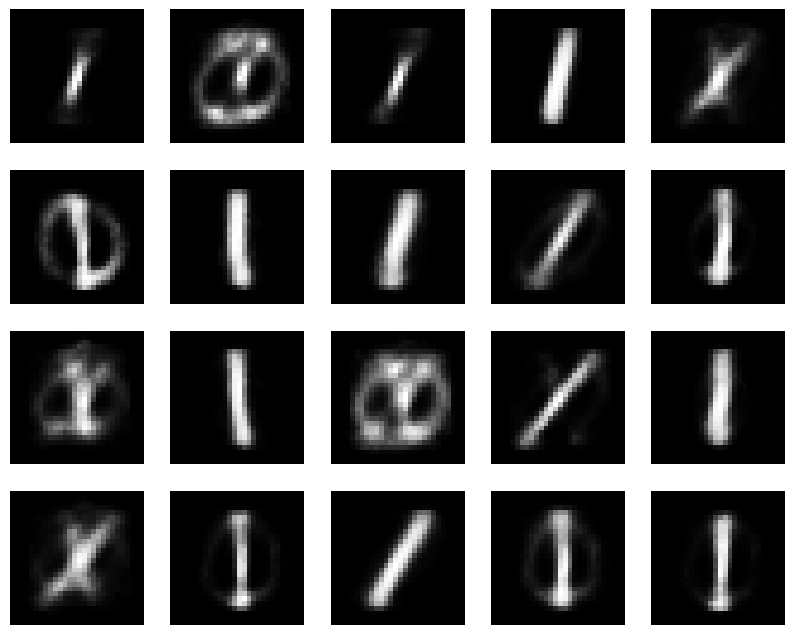

In [191]:
model.eval()
with torch.no_grad():
    # Sample latent vectors
    z = torch.randn(20, 20).to(device)
    samples = model.decoder(z).cpu()

# Display samples (should show both 0s and 1s)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].view(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

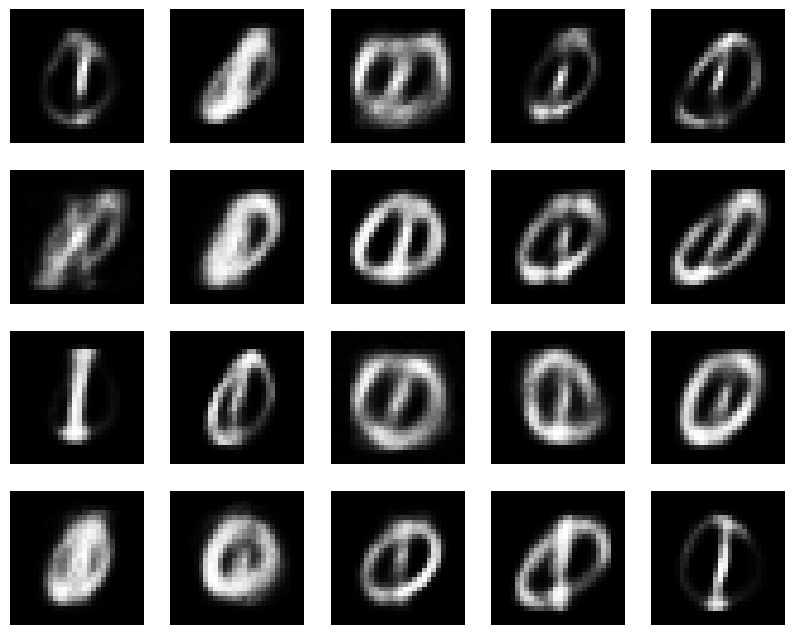

In [ ]:
model.eval()
with torch.no_grad():
    # Sample latent vectors
    z = torch.randn(20, 20).to(device)
    samples = model.decoder(z).cpu()

# Display samples (should show both 0s and 1s)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].view(28, 28), cmap='gray')
    ax.axis('off')
plt.show()